# Setting Up Environment

## Needed Libraries
- Numpy
- Pandas
- Matplotlib
- Sklearn
- Tensorflow

### pip install -r requirements.txt
### bash createEnv.sh for virtual environment (need virtualenv installed)

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

# Load Data

The dataset consists of 13 mature projects from the Apache Software Foundation, which are popular open-source Java projects hosted on GitHub. These curated projects were selected with respect to both project size and activity.
The goal of selecting metrics is to identify patterns in their values to allow distinguishing between the two classes of fragments. To do so, we gathered all the metrics that have been extensively used in previous studies and then removed all the redundant metrics to avoid generating features with similar values. In total,we selected 78 metrics that can be related to the code fragments, enclosing methods, and coupling.


In [6]:
metrics = pd.read_csv('metricData.zip', index_col=0).drop_duplicates()

In [8]:
metrics.head()

,TotalLinesOfCode,TotalSymbols,SymbolsPerLine,Area,AreaPerLine,TotalConnectivity,TotalConnectivityPerLine,FieldConnectivity,FieldConnectivityPerLine,MethodConnectivity,...,KeywordLongCountPerLine,KeywordStrictfpTotalCount,KeywordStrictfpCountPerLine,KeywordFloatTotalCount,KeywordFloatCountPerLine,KeywordSuperTotalCount,KeywordSuperCountPerLine,KeywordWhileTotalCount,KeywordWhileCountPerLine,label
0,25.0,1127.0,45.080000,63.0,2.520000,1.0,0.033333,1.0,0.033333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,6.0,170.0,28.333333,1.0,0.166667,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2.0,39.0,19.500000,0.0,0.000000,2.0,1.000000,1.0,0.500000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,6.0,223.0,37.166667,3.0,0.500000,1.0,0.200000,1.0,0.200000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2.0,111.0,55.500000,0.0,0.000000,1.0,0.333333,1.0,0.333333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# Class Imbalance

We see that there is high class imbalance in our data between negative (should not be refactored) and postive (should be refactored) samples. This will cause an issue further on when we train our model because it will favor labeling everything as negative because that is what it is seeing in the data (we could achieve 90%+ accuracy by guessing everything is negative, because 90%+ of the data is negative samples). 

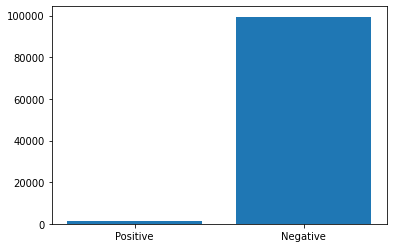

In [9]:
positives = metrics[metrics["label"] == 1]
negatives = metrics[metrics["label"] == 0]

plt.bar(["Positive","Negative"],[len(positives),len(negatives)]);

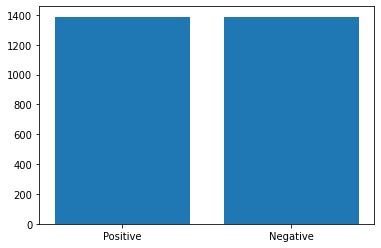

In [10]:
balanceNegatives = negatives.sample(frac=1)[:len(positives)]

plt.bar(["Positive","Negative"],[len(positives),len(balanceNegatives)]);

In [14]:
balanceMetrics = pd.concat([positives,balanceNegatives]).sample(frac = 1)

# Data Processing

Here we will process our data for our model. This processing will include
- feature-label separation 
- train-test split
- feature normalization
- shaping feature vectors

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
features = balanceMetrics.iloc[:,:-1]
labels = balanceMetrics.iloc[:,-1]

In [17]:
trainX = features.iloc[:int(.8*len(features))]
trainY = labels.iloc[:int(.8*len(features))]

testX = features.iloc[int(.8*len(features)):]
testY = labels.iloc[int(.8*len(features)):]

In [18]:
scaler = StandardScaler()
scaler.fit(trainX)
trainX = scaler.transform(trainX)
testX = scaler.transform(testX)


In [19]:
#Reshape data for CNN
trainX = trainX[..., None]
trainY = trainY[..., None]

testX = testX[..., None]
testY = testY[..., None]

/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_4356/1448998680.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  trainY = trainY[..., None]
/var/folders/fr/03zv9zcj7j146mrr4jsb58kw0000gn/T/ipykernel_4356/1448998680.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  testY = testY[..., None]


# Model Creation

We will create our Convolutional Neural Network here by stacking together many sequential layers. These layers can be change as long as the end layer is a single dense node that gives our prediction.

Layers used are:
- 1D convolution layers
- Max Pooling Layers
- Dropout "Layers"
- Fully Connected Dense Layers

## Model Training

After building our model, we will train it on the processed training data we created above. The model will learn that data and then we can evaluate its accuracy.

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras import layers, models
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [29]:
batch_size=64
num_epochs = 15
    
model = Sequential()

model.add((Conv1D(filters=32, kernel_size=3, activation='relu')))
model.add((Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add((MaxPooling1D(pool_size=2)))
model.add(Dropout(0.25))
model.add((Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add((MaxPooling1D(pool_size=2)))
model.add(Dropout(0.25))
model.add((Conv1D(filters=128, kernel_size=3, activation='relu')))
model.add((MaxPooling1D(pool_size=2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

adam = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

model.compile(optimizer=adam, loss='binary_crossentropy', metrics=["accuracy",
                                                                  tf.keras.metrics.Precision(),
                                                                  tf.keras.metrics.Recall()])

In [30]:
model.fit(trainX, trainY, epochs = num_epochs, batch_size=batch_size)

Epoch 1/15
35/35 [==============================] - 2s 30ms/step - loss: 0.6876 - accuracy: 0.5784 - precision_1: 0.5877 - recall: 0.5531
Epoch 2/15
35/35 [==============================] - 1s 28ms/step - loss: 0.6618 - accuracy: 0.6068 - precision_1: 0.6330 - recall: 0.5263
Epoch 3/15
35/35 [==============================] - 1s 27ms/step - loss: 0.6299 - accuracy: 0.6437 - precision_1: 0.6687 - recall: 0.5834
Epoch 4/15
35/35 [==============================] - 1s 28ms/step - loss: 0.6042 - accuracy: 0.6671 - precision_1: 0.6823 - recall: 0.6378
Epoch 5/15
35/35 [==============================] - 1s 31ms/step - loss: 0.5864 - accuracy: 0.6874 - precision_1: 0.6975 - recall: 0.6726
Epoch 6/15
35/35 [==============================] - 1s 34ms/step - loss: 0.5677 - accuracy: 0.7000 - precision_1: 0.7148 - recall: 0.6753
Epoch 7/15
35/35 [==============================] - 1s 34ms/step - loss: 0.5523 - accuracy: 0.7032 - precision_1: 0.7108 - recall: 0.6949
Epoch 8/15
35/35 [================

# Model Evaluation 

Once our model is trained, we want to test the actual accuracy on our test set. We also want to ensure that we did not over train our model on our training set. First we will check the inital accuracy of the model, then check for over training with Kfolds cross validation.

The metrics we want to use to evaluate our model are:
- Accuracy 
- Precision 
- Recall

In [31]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

In [38]:
def newModel():
    
    model = Sequential()

    model.add((Conv1D(filters=32, kernel_size=3, activation='relu')))
    model.add((Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add((MaxPooling1D(pool_size=2)))
    model.add(Dropout(0.25))
    model.add((Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add((MaxPooling1D(pool_size=2)))
    model.add(Dropout(0.25))
    model.add((Conv1D(filters=128, kernel_size=3, activation='relu')))
    model.add((MaxPooling1D(pool_size=2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(100, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))

    adam = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=["accuracy",
                                                                  tf.keras.metrics.Precision(),
                                                                  tf.keras.metrics.Recall()])
    return model


In [39]:
model.evaluate(testX,testY)

18/18 [==============================] - 0s 5ms/step - loss: 0.4613 - auc_6: 0.8569 - precision_at_recall_6: 0.7224


[0.46134960651397705, 0.8568755984306335, 0.7224080562591553]

In [42]:
X = np.concatenate([trainX, testX])
Y = np.concatenate([trainY, testY])

batch=64
num_epochs = 15

kfold = KFold(n_splits=10, shuffle=True)
fold_no = 1

accuracy = []
precision = []
recall = []

for train, test in kfold.split(X, Y):
    model = newModel()
    history = model.fit(X[train], Y[train], epochs = num_epochs, batch_size=batch, verbose = 0)
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print(f'fold {fold_no}: {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]}; {model.metrics_names[3]} of {scores[3]}')
    fold_no = fold_no + 1
    
    accuracy.append(scores[1])
    precision.append(scores[2])
    recall.append(scores[3])
    


fold 1: accuracy of 0.7589927911758423; precision_8 of 0.748344361782074; recall_7 of 0.7957746386528015
fold 2: accuracy of 0.730215847492218; precision_9 of 0.7592592835426331; recall_8 of 0.6259542107582092
fold 3: accuracy of 0.7841726541519165; precision_10 of 0.7844827771186829; recall_9 of 0.7222222089767456
fold 4: accuracy of 0.7446042895317078; precision_11 of 0.8095238208770752; recall_10 of 0.6845637559890747
fold 5: accuracy of 0.6870503425598145; precision_12 of 0.7307692170143127; recall_11 of 0.5629629492759705
fold 6: accuracy of 0.7589927911758423; precision_13 of 0.7365269660949707; recall_12 of 0.8424657583236694
fold 7: accuracy of 0.7148014307022095; precision_14 of 0.75; recall_13 of 0.6938775777816772
fold 8: accuracy of 0.7328519821166992; precision_15 of 0.738095223903656; recall_14 of 0.6940298676490784
fold 9: accuracy of 0.7328519821166992; precision_16 of 0.7111111283302307; recall_15 of 0.732824444770813
fold 10: accuracy of 0.750902533531189; precision_1

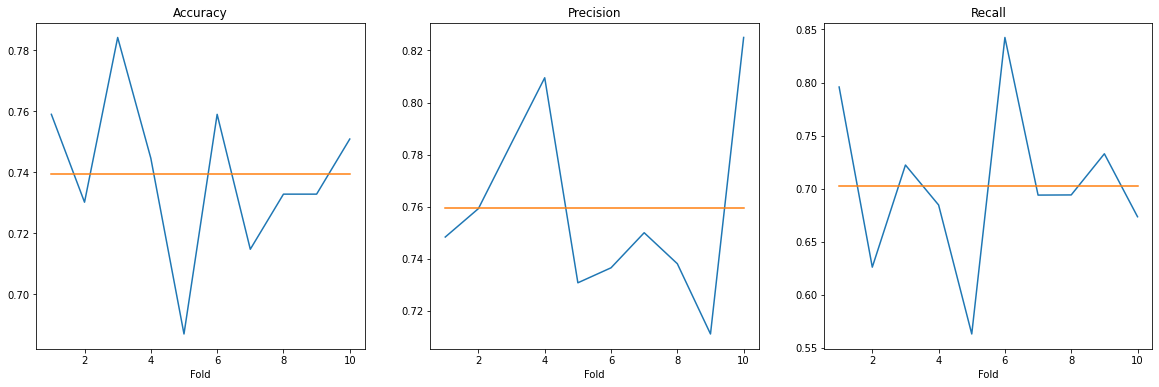

In [51]:
folds = np.arange(1,11,1)

plt.figure(figsize = (20,6))

plt.subplot(1,3,1)
plt.plot(folds,accuracy)
plt.plot(folds,np.full(len(folds),np.mean(accuracy)))
plt.title("Accuracy")
plt.xlabel("Fold")

plt.subplot(1,3,2)
plt.plot(folds,precision)
plt.plot(folds,np.full(len(folds),np.mean(precision)))
plt.title("Precision")
plt.xlabel("Fold")

plt.subplot(1,3,3)
plt.plot(folds,recall)
plt.plot(folds,np.full(len(folds),np.mean(recall)))
plt.title("Recall")
plt.xlabel("Fold");
